[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


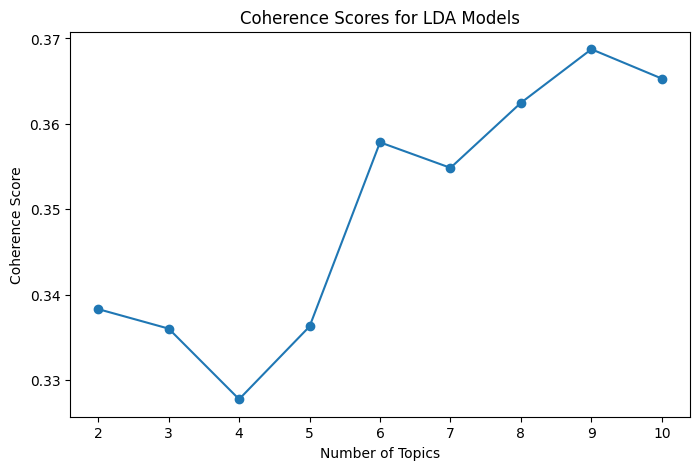

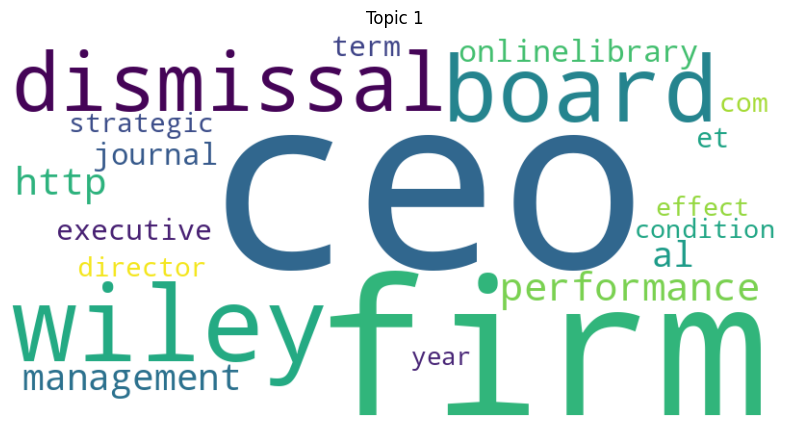

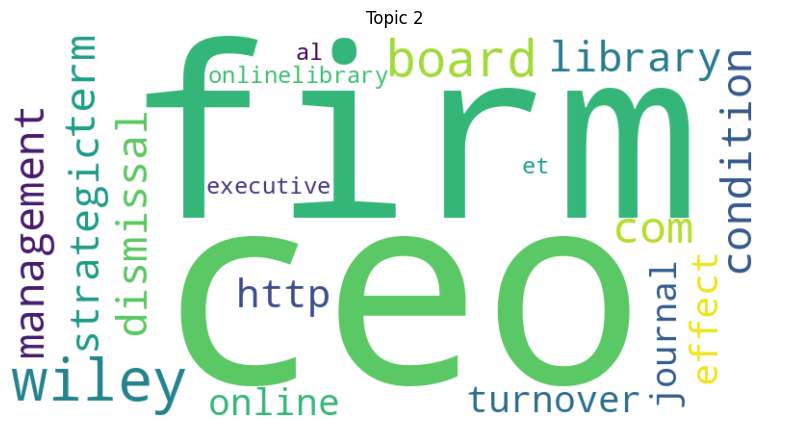

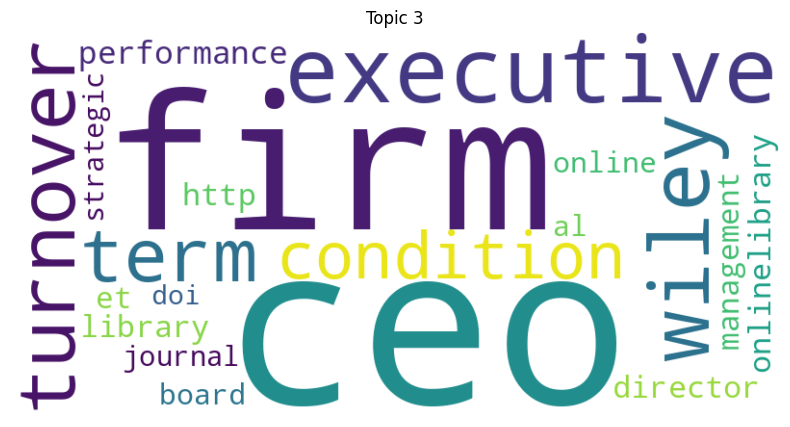

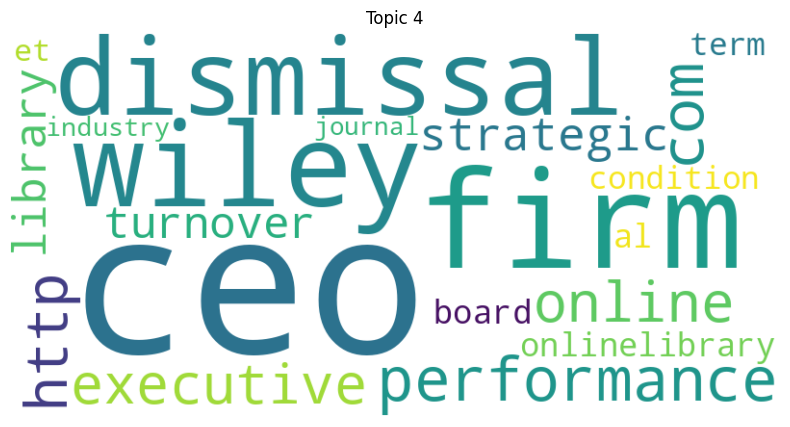

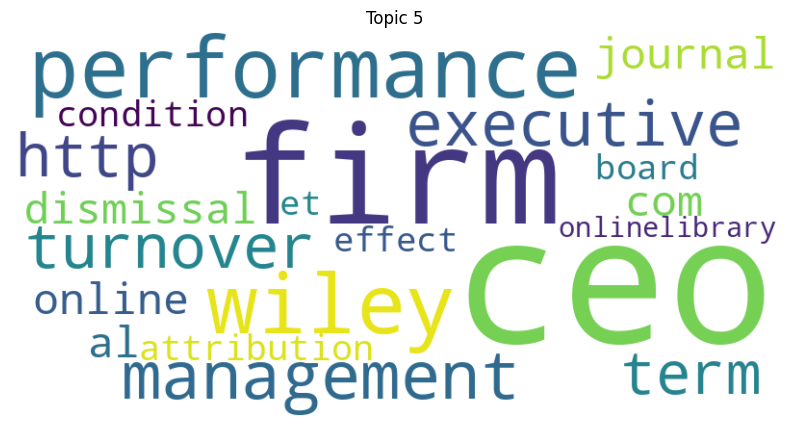

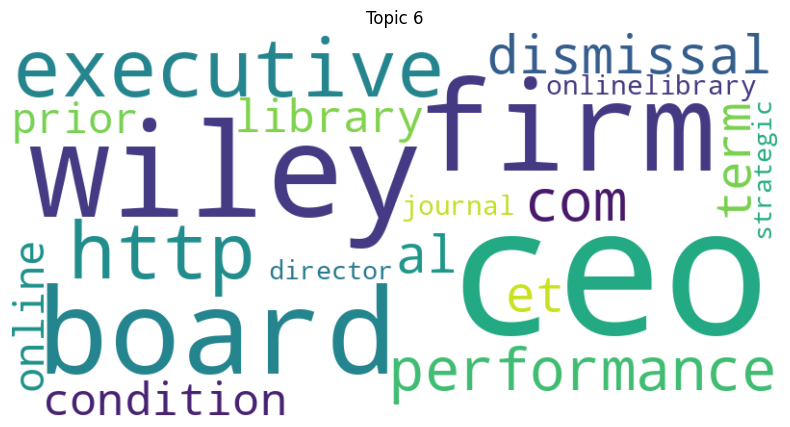

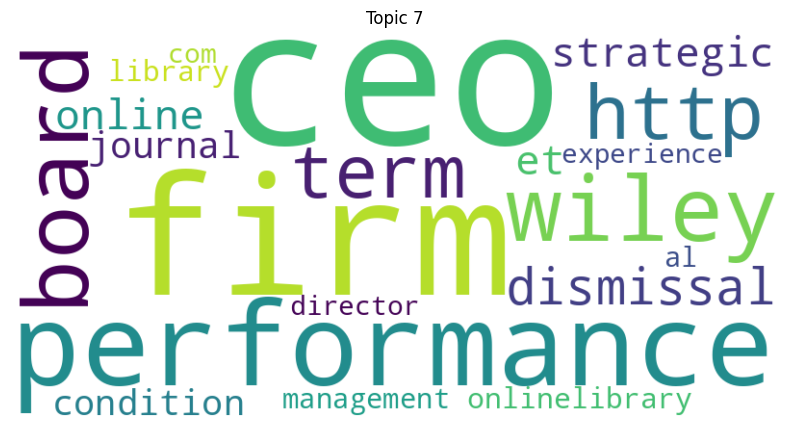

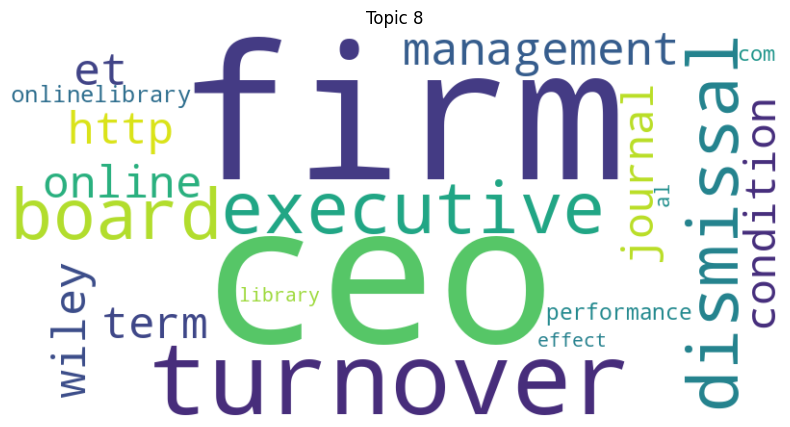

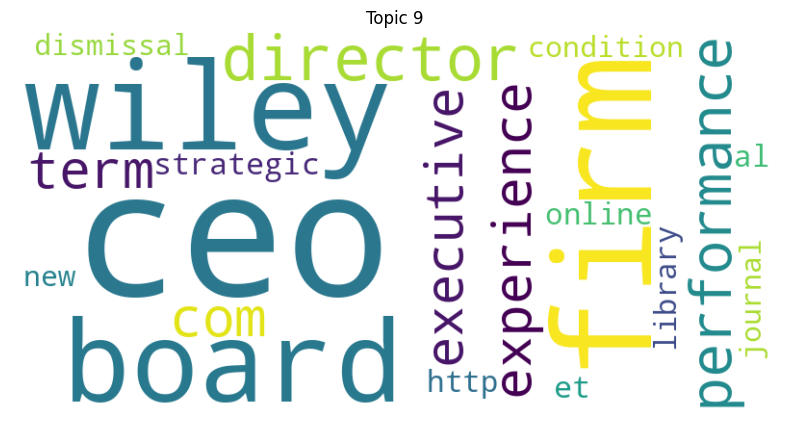

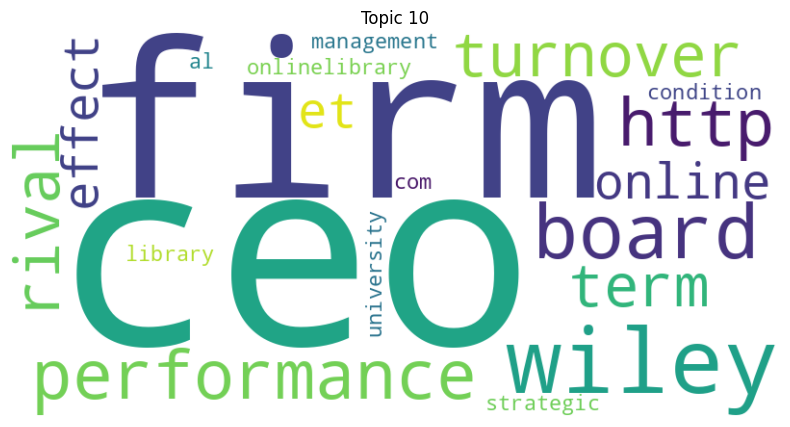

Topic modeling completed. Check the following files:
- topic_model_results.docx: Coherence scores.
- coherence_scores.jpg: Plot of coherence scores.
- topic_X_wordcloud.jpg: Word clouds for each topic.


In [3]:
import os
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
from gensim.models import LdaModel, CoherenceModel
import matplotlib.pyplot as plt
from wordcloud import WordCloud
!pip install nltk
import nltk
nltk.download('wordnet')

from google.colab import drive
drive.mount('/content/drive')

# Step 1: Load and preprocess text files
def load_text_files(folder_path):
    documents = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                documents.append(file.read())
    return documents



def preprocess(text):
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in simple_preprocess(text) if token not in STOPWORDS]
    return tokens if len(tokens) > 2 else ["placeholder_word"]

folder_path = "/content/drive/My Drive/test1/local_data"
documents = load_text_files(folder_path)
processed_docs = [preprocess(doc) for doc in documents]

# Create dictionary and corpus
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Step 2: Train LDA models and compute coherence scores
coherence_scores = []
num_topics_range = range(2, 11)

for num_topics in num_topics_range:
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
    coherence_model = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

# Save coherence scores to a file
with open("topic_model_results.docx", "w") as f:
    for num_topics, score in zip(num_topics_range, coherence_scores):
        f.write(f"Number of Topics: {num_topics}, Coherence Score: {score}\n")

# Step 3: Plot coherence scores
plt.figure(figsize=(8, 5))
plt.plot(num_topics_range, coherence_scores, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores for LDA Models")
plt.savefig("coherence_scores.jpg")
plt.show()

# Step 4: Tune hyperparameters for the best model
#best_num_topics = num_topics_range[coherence_scores.index(max(coherence_scores))]
best_num_topics = 10


lda_model_tuned = LdaModel(corpus=corpus, id2word=dictionary, num_topics=best_num_topics, alpha='auto', eta='auto', random_state=42)
coherence_model_tuned = CoherenceModel(model=lda_model_tuned, texts=processed_docs, dictionary=dictionary, coherence='c_v')
tuned_coherence_score = coherence_model_tuned.get_coherence()

# Save tuned coherence score
with open("topic_model_results.docx", "a") as f:
    f.write(f"\nBest Model (Tuned): Number of Topics: {best_num_topics}, Coherence Score: {tuned_coherence_score}\n")

# Step 5: Generate word clouds for each topic
for topic_id in range(best_num_topics):
    words = dict(lda_model_tuned.show_topic(topic_id, topn=20))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic_id + 1}")
    plt.savefig(f"topic_{topic_id + 1}_wordcloud.jpg")
    plt.show()

# Step 7: Evaluate the results
print("Topic modeling completed. Check the following files:")
print("- topic_model_results.docx: Coherence scores.")
print("- coherence_scores.jpg: Plot of coherence scores.")
print("- topic_X_wordcloud.jpg: Word clouds for each topic.")